In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('/home/student/Desktop/220962049_aiml/daily_csv.csv')
df['Price'].interpolate(method='linear', inplace=True)

prices = torch.Tensor(df['Price'].values)
prices = (prices - prices.min()) / (prices.max() - prices.min())


n = int(0.75 * len(prices))
train, test = prices[:n], prices[n:]

/tmp/ipykernel_7615/1615506271.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].interpolate(method='linear', inplace=True)


In [13]:
class TimeSeriesDataset(Dataset):

    def __init__(self, series, seq_length=10, device="cpu"):
        self.series = series
        self.seq_length = seq_length

    def __len__(self):
        return len(self.series) - self.seq_length - 1

    def __getitem__(self, idx):
        X = self.series[idx:idx+self.seq_length].reshape(self.seq_length, -1)
        y = self.series[idx+self.seq_length]

        return X, y

In [14]:
train_dataset = TimeSeriesDataset(train, seq_length=10)
test_dataset = TimeSeriesDataset(test, seq_length=10)
train_data = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [15]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size):

        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True) 
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=1), 
        )

    def forward(self, x):
        output, status = self.rnn(x)
        output = output[:, -1, :] 
        output = self.fc(output)

        return output

In [16]:
input_size = 1
hidden_size = 5
learning_rate = 1e-4
num_epochs = 1500

model = RNN(input_size, hidden_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")  # Print progress manually

    for i, (batch, targets) in enumerate(train_data):
        outs = model(batch).reshape(-1)

        optimizer.zero_grad()
        loss = criterion(outs, targets)
        loss.backward()
        optimizer.step()

        # Print progress for every 10th batch (optional)
        if i % 10 == 0:
            print(f"  Batch {i+1}/{len(train_data)}, Loss: {loss.item()}")

    if epoch % 50 == 0:
        print(f"After epoch {epoch}, loss={loss.item()}")


Epoch 1/1500
  Batch 1/18, Loss: 0.11919968575239182
  Batch 11/18, Loss: 0.12547309696674347
After epoch 0, loss=0.13013996183872223
Epoch 2/1500
  Batch 1/18, Loss: 0.12171542644500732
  Batch 11/18, Loss: 0.1268751472234726
Epoch 3/1500
  Batch 1/18, Loss: 0.11319871991872787
  Batch 11/18, Loss: 0.11807101964950562


Exception ignored in: <function tqdm.__del__ at 0x7b7bac2d1440>
Traceback (most recent call last):
  File "/home/student/Desktop/220962049_aiml/.venv/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/student/Desktop/220962049_aiml/.venv/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7b7bac2d1440>
Traceback (most recent call last):
  File "/home/student/Desktop/220962049_aiml/.venv/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/student/Desktop/220962049_aiml/.venv/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__d

Epoch 4/1500
  Batch 1/18, Loss: 0.09817495942115784
  Batch 11/18, Loss: 0.09976417571306229
Epoch 5/1500
  Batch 1/18, Loss: 0.10425276309251785
  Batch 11/18, Loss: 0.10317812860012054
Epoch 6/1500
  Batch 1/18, Loss: 0.10056265443563461
  Batch 11/18, Loss: 0.08929745107889175
Epoch 7/1500
  Batch 1/18, Loss: 0.08626741915941238
  Batch 11/18, Loss: 0.08390000462532043
Epoch 8/1500
  Batch 1/18, Loss: 0.0923704281449318
  Batch 11/18, Loss: 0.08358245342969894
Epoch 9/1500
  Batch 1/18, Loss: 0.0924082100391388
  Batch 11/18, Loss: 0.07853900641202927
Epoch 10/1500
  Batch 1/18, Loss: 0.07400530576705933
  Batch 11/18, Loss: 0.07850398123264313
Epoch 11/1500
  Batch 1/18, Loss: 0.07112006843090057
  Batch 11/18, Loss: 0.08380073308944702
Epoch 12/1500
  Batch 1/18, Loss: 0.07653547078371048
  Batch 11/18, Loss: 0.0697365403175354
Epoch 13/1500
  Batch 1/18, Loss: 0.06071791052818298
  Batch 11/18, Loss: 0.06842710822820663
Epoch 14/1500
  Batch 1/18, Loss: 0.061407480388879776
  Ba

In [25]:
preds = []
targets = []

for i, (batch, target) in enumerate(test_data):
    preds.append(model(batch).item())
    targets.append(target.item())
    if i % 10 == 0:
        print(f"Processing batch {i+1}/{len(test_data)}")

print("Prediction completed!")


Processing batch 1/1478
Processing batch 11/1478
Processing batch 21/1478
Processing batch 31/1478
Processing batch 41/1478
Processing batch 51/1478
Processing batch 61/1478
Processing batch 71/1478
Processing batch 81/1478
Processing batch 91/1478
Processing batch 101/1478
Processing batch 111/1478
Processing batch 121/1478
Processing batch 131/1478
Processing batch 141/1478
Processing batch 151/1478
Processing batch 161/1478
Processing batch 171/1478
Processing batch 181/1478
Processing batch 191/1478
Processing batch 201/1478
Processing batch 211/1478
Processing batch 221/1478
Processing batch 231/1478
Processing batch 241/1478
Processing batch 251/1478
Processing batch 261/1478
Processing batch 271/1478
Processing batch 281/1478
Processing batch 291/1478
Processing batch 301/1478
Processing batch 311/1478
Processing batch 321/1478
Processing batch 331/1478
Processing batch 341/1478
Processing batch 351/1478
Processing batch 361/1478
Processing batch 371/1478
Processing batch 381/14

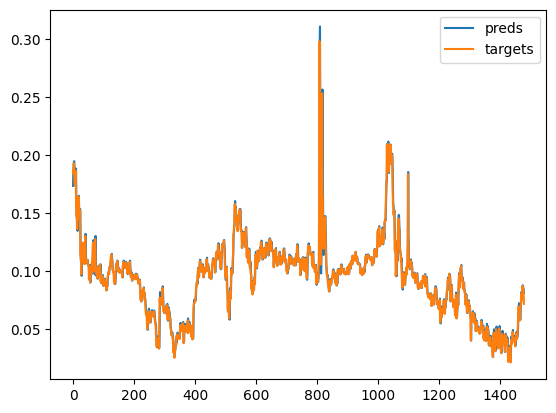

In [26]:
plt.plot(range(len(test_data)), preds, label="preds")
plt.plot(range(len(test_data)), targets, label="targets")
plt.legend()
plt.show()